Import the libraries necessary to analize data

In [10]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [11]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   date                                197914 non-null  datetime64[ns]
 1   state                               197914 non-null  object        
 2   city_or_county                      197914 non-null  object        
 3   latitude                            197914 non-null  float64       
 4   longitude                           197914 non-null  float64       
 5   congressional_district              197914 non-null  int64         
 6   avg_age_participants                197914 non-null  float64       
 7   n_participants_child                197914 non-null  int64         
 8   n_participants_teen                 197914 non-null  int64         
 9   n_participants_adult                197914 non-null  int64         
 10  n_males 

Since in the TASK 3, we need to define a boolean variable representing the class, we decide to pre-calculate it to label the PCA results after the normalization and see how the class is distributed

In [12]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0) 

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [13]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing',
       ]
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)

In [14]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]
numeric_attributes

['povertyPercentage',
 'males_percentage_per_district',
 'child_teen_percentage_per_district',
 'killed_percentage_per_district',
 'injured_percentage_per_district',
 'arrested_percentage_per_district',
 'unharmed_percentage_per_district',
 'killed_rate',
 'injured_rate',
 'arrested_rate',
 'survival_rate',
 'winning_party_percentage']

<Axes: >

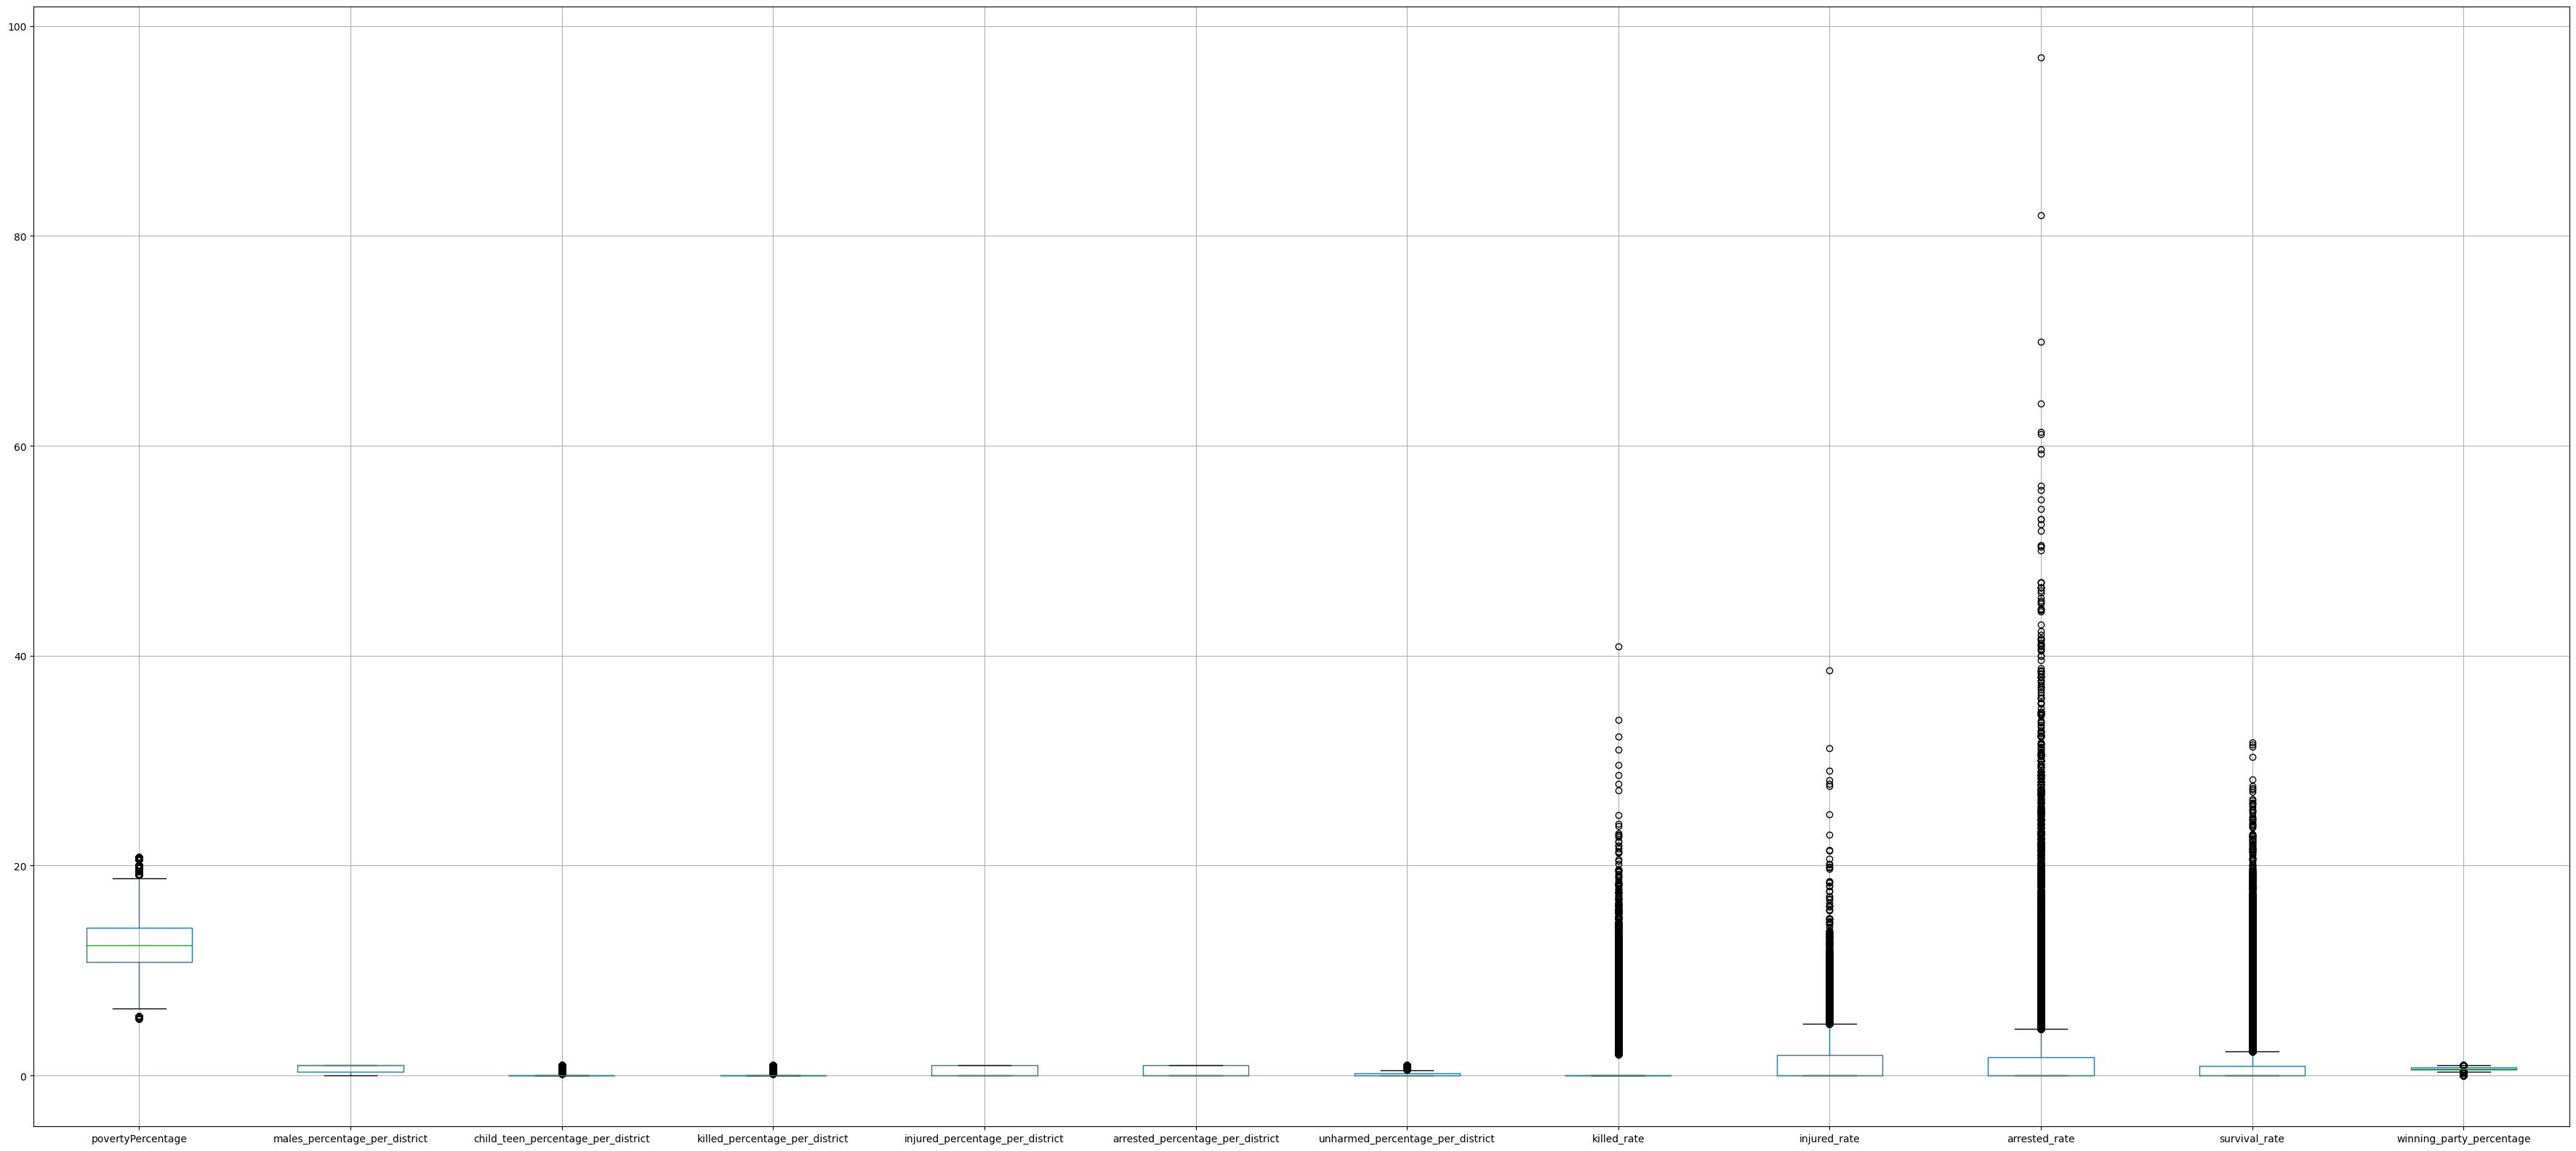

In [15]:
df[numeric_attributes].boxplot(figsize=(45,20))

In [16]:
attr_to_log = ['avg_age_participants', 'povertyPercentage', 'arrested_rate', 'injured_rate', 'killed_rate', 'injured_percentage_per_district']
df[attr_to_log] = np.log(df[attr_to_log].values)
df[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)
df[attr_to_log] = df[attr_to_log].fillna(value=0)

C:\Users\mitol\AppData\Local\Temp\ipykernel_10864\1363235484.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr_to_log] = np.log(df[attr_to_log].values)


In [17]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 12 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   povertyPercentage                   197914 non-null  float64
 1   males_percentage_per_district       197914 non-null  float64
 2   child_teen_percentage_per_district  197914 non-null  float64
 3   killed_percentage_per_district      197914 non-null  float64
 4   injured_percentage_per_district     197914 non-null  float64
 5   arrested_percentage_per_district    197914 non-null  float64
 6   unharmed_percentage_per_district    197914 non-null  float64
 7   killed_rate                         197914 non-null  float64
 8   injured_rate                        197914 non-null  float64
 9   arrested_rate                       197914 non-null  float64
 10  survival_rate                       197914 non-null  float64
 11  winning_party_percentage  

## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

## PCA

We do the PCA analysis to visualize in 2D the distribution of our multi-dimensional data

In [19]:
scaled_df[column_to_drop] = df[column_to_drop]

In [20]:
pca = PCA(n_components=2)

In [21]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

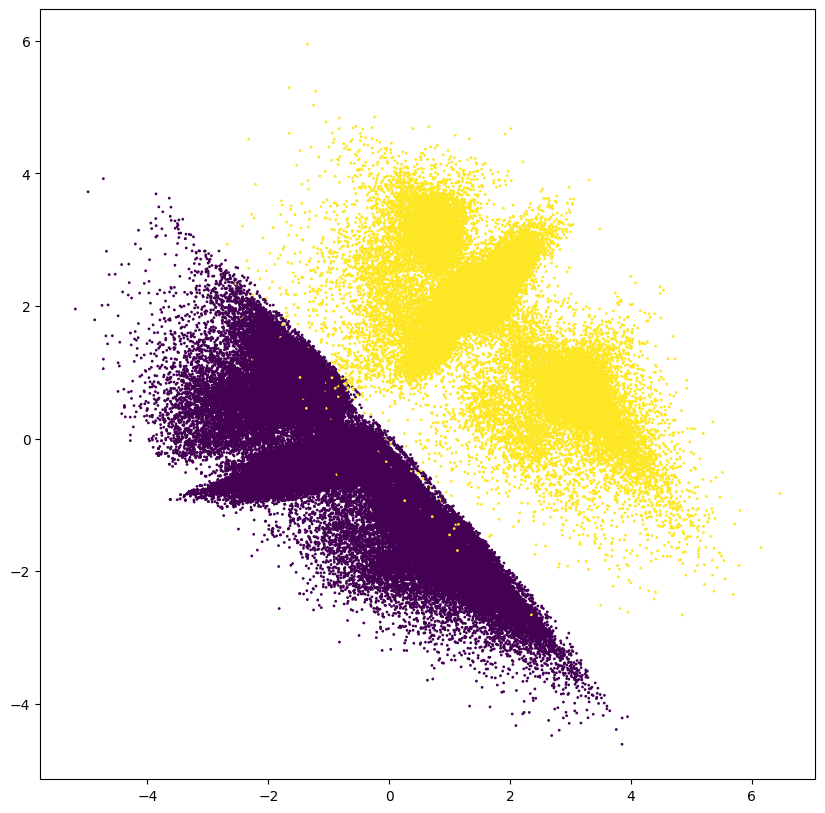

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_killing'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
#plt.legend(handles, scaled_df['state'].unique())

# display the plot
plt.show()

## Saving the normalized dataset

In [23]:
scaled_df.to_csv('df_scaled.csv', index=False)